
# Binary Logistic Stress Detector



This notebook distills the best-performing elements from prior experiments into a lean, auditable binary classifier that detects whether a subject is stressed or not. The focus is on:

- Rigorous exploratory analysis of the engineered window-level features.
- Subject-specific normalization so the model learns deviations from each person's baseline.
- Transparent handling of the severe class imbalance before fitting a logistic regression detector.
- An 80/20 subject-level split (no folds) to create a held-out evaluation set.
- Multiple imbalance strategies (class weights, under/oversampling hybrids, threshold tuning) with comparable metrics.


In [2]:

import warnings
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    precision_recall_fscore_support,
    roc_auc_score,
)
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)


In [3]:
DATA_ROOT = Path('.').resolve()
FEATURE_PATH = DATA_ROOT / 'complete_enhanced_dataset.csv'
STRESS_LEVEL_FILES = [
    DATA_ROOT / 'Stress_Level_v1.csv',
    DATA_ROOT / 'Stress_Level_v2.csv',
]
SUBJECT_INFO_PATH = DATA_ROOT / 'subject-info.csv'
RANDOM_STATE = 42
BASELINE_PHASES = {"baseline", "rest"}
TEST_SIZE = 0.2
OUTLIER_FEATURES = [
    'motion_ratio',
    'eda_range',
    'hr_mean',
    'hrv_rmssd',
    'temp_range',
]

np.random.seed(RANDOM_STATE)
print(f"Data root: {DATA_ROOT}")


Data root: /Users/s7s/Desktop/Uni/Fall 25/Mining/Project/Stress-Level-Prediction


In [4]:

features_df = pd.read_csv(FEATURE_PATH)
print(f"Loaded engineered window dataset with shape: {features_df.shape}")

stress_level_tables = []
for path in STRESS_LEVEL_FILES:
    if path.exists():
        tbl = pd.read_csv(path, index_col=0)
        tbl.columns = [str(c).strip() for c in tbl.columns]
        stress_level_tables.append(tbl)
        print(f"Loaded stress ratings table: {path.name} -> {tbl.shape}")

subject_info = None
if SUBJECT_INFO_PATH.exists():
    subject_info = pd.read_csv(SUBJECT_INFO_PATH)
    print(f"Subject metadata rows: {subject_info.shape[0]}")


Loaded engineered window dataset with shape: (6784, 48)
Loaded stress ratings table: Stress_Level_v1.csv -> (18, 8)
Loaded stress ratings table: Stress_Level_v2.csv -> (18, 7)
Subject metadata rows: 46


In [5]:

def label_from_score(score: float) -> str:
    if pd.isna(score):
        return np.nan
    if score >= 6.0:
        return 'high_stress'
    if score >= 3.0:
        return 'moderate_stress'
    if score > 0.0:
        return 'low_stress'
    return 'no_stress'

features_df['score_based_label'] = features_df['stress_score'].apply(label_from_score)
label_mismatches = features_df[
    features_df['score_based_label'].notna() &
    features_df['label'].notna() &
    (features_df['label'] != features_df['score_based_label'])
]
print(f"Potential label mismatches: {label_mismatches.shape[0]}")
if not label_mismatches.empty:
    display(label_mismatches[['subject', 'protocol', 'phase', 'stress_score', 'label', 'score_based_label']].head())

features_df.drop(columns=['score_based_label'], inplace=True)


Potential label mismatches: 2199


,subject,protocol,phase,stress_score,label,score_based_label
0,f03,STRESS,Baseline,5.0,low_stress,moderate_stress
1,f03,STRESS,Baseline,5.0,low_stress,moderate_stress
2,f03,STRESS,Baseline,5.0,low_stress,moderate_stress
3,f03,STRESS,Baseline,5.0,low_stress,moderate_stress
4,f03,STRESS,Baseline,5.0,low_stress,moderate_stress



## Data Quality Snapshot


Top missing features (%):


stress_score       63.576061
hrv_mean_hr         5.689858
hrv_hf              5.689858
hrv_lf_hf_ratio     5.689858
hrv_std_rr          5.689858
hrv_rmssd           5.689858
hrv_sampen          5.689858
hrv_lf              5.689858
hrv_mean_rr         5.689858
hrv_apen            5.689858
dtype: float64

Label distribution:


label
no_stress          2210
low_stress         1499
aerobic            1096
anaerobic           833
unknown             562
moderate_stress     363
high_stress         221
Name: count, dtype: int64

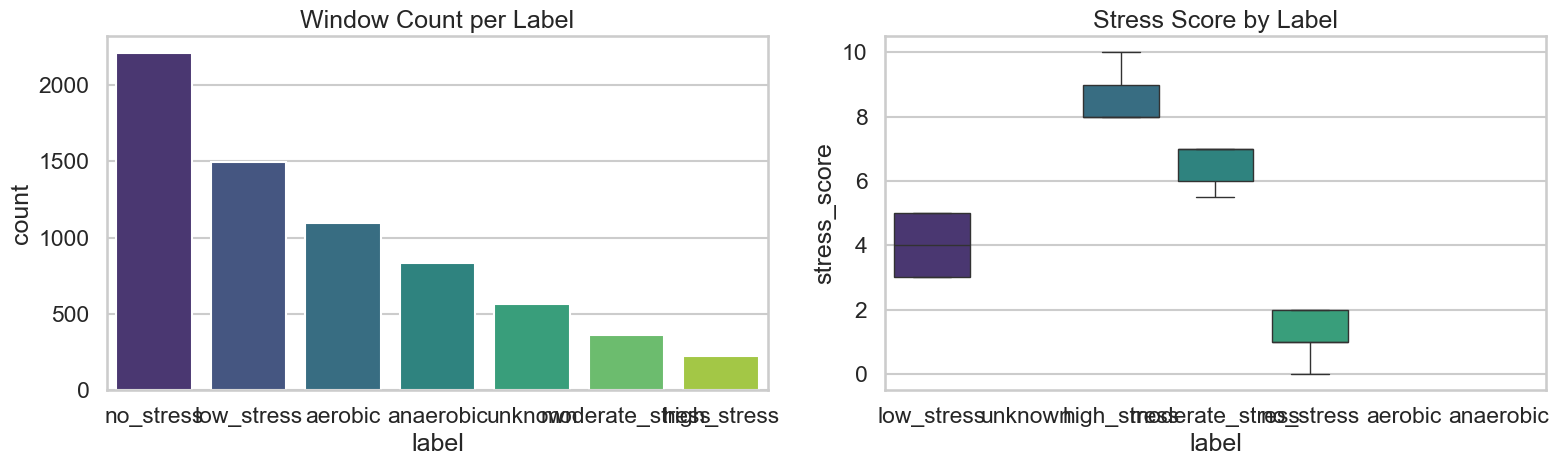

label                aerobic  anaerobic  high_stress  low_stress  \
protocol  phase                                                    
AEROBIC   aerobic       1035          0            0           0   
          rest             0          0            0           0   
          unknown         61          0            0           0   
ANAEROBIC anaerobic        0        770            0           0   
          rest             0          0            0           0   

label                moderate_stress  no_stress  unknown  
protocol  phase                                           
AEROBIC   aerobic                  0          0        0  
          rest                     0       1043        0  
          unknown                  0          0        0  
ANAEROBIC anaerobic                0          0        0  
          rest                     0        779        0

In [7]:

missing_pct = features_df.isna().mean().sort_values(ascending=False)
print("Top missing features (%):")
display((missing_pct * 100).head(10))

class_counts = features_df['label'].value_counts().rename('count')
print("Label distribution:")
display(class_counts)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Window Count per Label')
axes[0].set_ylabel('count')
axes[0].set_xlabel('label')

sns.boxplot(data=features_df, x='label', y='stress_score', ax=axes[1], palette='viridis')
axes[1].set_title('Stress Score by Label')
axes[1].set_xlabel('label')
axes[1].set_ylabel('stress_score')
plt.tight_layout()
plt.show()

phase_counts = features_df.groupby(['protocol', 'phase'])['label'].value_counts().unstack(fill_value=0)
display(phase_counts.head())


Numeric summary (first 10 rows):


,count,mean,std,min,25%,50%,75%,max
eda_scl_mean,6784.0,0.001868,0.126033,-2.442600,-0.009571,0.000021,0.010640,1.826950
eda_scl_std,6784.0,0.203358,0.408433,0.000088,0.008065,0.067908,0.220543,5.893238
eda_scl_range,6784.0,0.692677,1.344880,0.000345,0.027769,0.239742,0.776882,18.531302
eda_phasic_mean,6784.0,0.000360,0.010888,-0.097917,-0.001016,-0.000013,0.000810,0.112952
eda_phasic_std,6784.0,0.137570,0.188765,0.000813,0.006348,0.063242,0.202969,1.721456
eda_phasic_energy,6784.0,13.121100,37.981768,0.000159,0.009687,0.962298,9.926882,711.828258
scr_count,6784.0,10.497199,8.573742,0.000000,2.000000,10.000000,17.000000,39.000000
scr_rate,6784.0,10.497199,8.573742,0.000000,2.000000,10.000000,17.000000,39.000000
scr_amp_mean,6784.0,0.143323,0.177043,0.000000,0.018261,0.077218,0.211646,1.835523
scr_amp_max,6784.0,0.406628,0.549879,0.000000,0.023412,0.194441,0.588443,5.003019


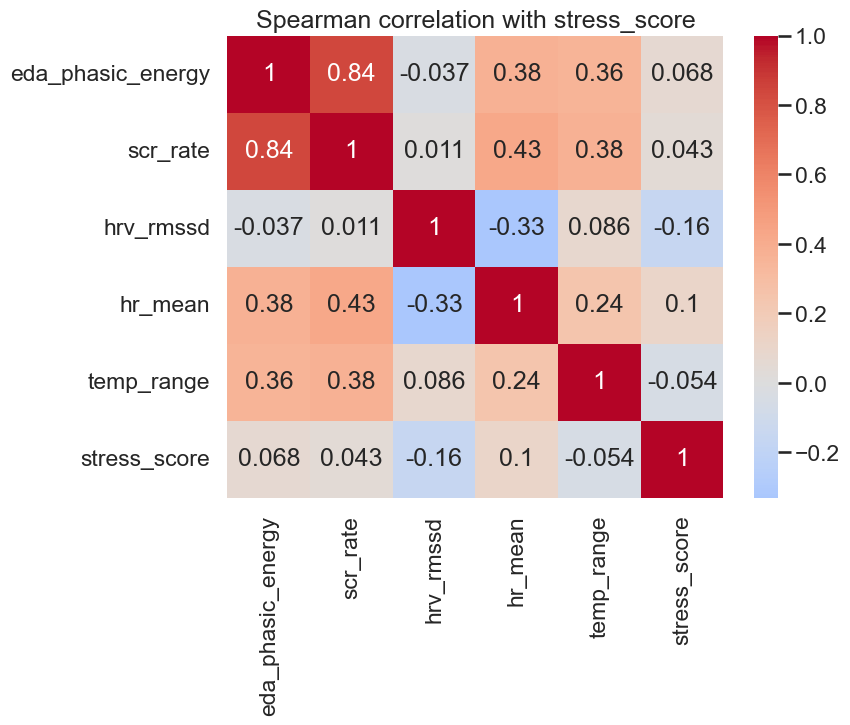

In [8]:

num_cols = features_df.select_dtypes(include=[np.number]).columns
numeric_summary = features_df[num_cols].describe().T
print("Numeric summary (first 10 rows):")
display(numeric_summary.head(10))

correlation_targets = ['eda_phasic_energy', 'scr_rate', 'hrv_rmssd', 'hr_mean', 'temp_range']
correlation_targets = [c for c in correlation_targets if c in num_cols]
if correlation_targets:
    corr_matrix = features_df[correlation_targets + ['stress_score']].corr(method='spearman')
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Spearman correlation with stress_score')
    plt.show()


In [9]:

available_outliers = [c for c in OUTLIER_FEATURES if c in features_df.columns]
clean_mask = pd.Series(True, index=features_df.index)
if available_outliers:
    zscores = np.abs(stats.zscore(features_df[available_outliers], nan_policy='omit'))
    zscores = pd.DataFrame(zscores, columns=available_outliers, index=features_df.index)
    clean_mask &= (zscores < 4.0).all(axis=1)

clean_df = features_df[clean_mask].reset_index(drop=True)
print(f"Removed {features_df.shape[0] - clean_df.shape[0]} outlier windows using {available_outliers}.")


Removed 470 outlier windows using ['motion_ratio', 'eda_range', 'hr_mean', 'hrv_rmssd', 'temp_range'].



## Subject-Specific Normalization


In [10]:

def normalize_by_subject_baseline(df: pd.DataFrame, feature_cols):
    normalized = df.copy()
    normalized_features = normalized[feature_cols].copy()
    baseline_labels = {p.lower() for p in BASELINE_PHASES}

    for subject, subject_df in df.groupby('subject'):
        subj_idx = subject_df.index
        baseline_idx = subject_df[subject_df['phase'].str.lower().isin(baseline_labels)].index
        if len(baseline_idx) == 0:
            baseline_idx = subj_idx
        mean = df.loc[baseline_idx, feature_cols].mean()
        std = df.loc[baseline_idx, feature_cols].std().replace(0, 1)
        normalized_features.loc[subj_idx] = (df.loc[subj_idx, feature_cols] - mean) / std

    normalized[feature_cols] = normalized_features
    normalized[feature_cols] = normalized[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return normalized

meta_cols = ['subject', 'protocol', 'phase', 'stress_score', 'label']
feature_cols = [col for col in clean_df.columns if col not in meta_cols]
feature_cols = clean_df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

normalized_df = normalize_by_subject_baseline(clean_df, feature_cols)
print(f"Normalized dataframe shape: {normalized_df.shape}")


Normalized dataframe shape: (6314, 48)


In [11]:

normalized_df['is_stress'] = (normalized_df['label'] != 'no_stress').astype(int)

feature_frame = normalized_df[feature_cols].reset_index(drop=True)
target_series = normalized_df['is_stress'].reset_index(drop=True)
group_series = normalized_df['subject'].reset_index(drop=True)
meta_frame = normalized_df[meta_cols + ['is_stress']].reset_index(drop=True)

splitter = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, test_idx = next(splitter.split(feature_frame, target_series, groups=group_series))

X_train = feature_frame.iloc[train_idx].copy()
X_test = feature_frame.iloc[test_idx].copy()
y_train = target_series.iloc[train_idx].to_numpy()
y_test = target_series.iloc[test_idx].to_numpy()
train_meta = meta_frame.iloc[train_idx].copy()
test_meta = meta_frame.iloc[test_idx].copy()

print(f"Training windows: {X_train.shape[0]} | Test windows: {X_test.shape[0]}")
print("Train class distribution:", Counter(y_train))
print("Test class distribution:", Counter(y_test))


Training windows: 5151 | Test windows: 1163
Train class distribution: Counter({1: 3549, 0: 1602})
Test class distribution: Counter({1: 768, 0: 395})



## Imbalance Strategies & Evaluation Helpers


In [12]:

def build_pipeline(C=1.0, class_weight='balanced'):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(
            penalty='l2',
            solver='liblinear',
            C=C,
            class_weight=class_weight,
            max_iter=2000,
            random_state=RANDOM_STATE,
        )),
    ])


def evaluate_strategy(name, sampler=None, class_weight='balanced', threshold_mode='best_f1', C=1.0):
    pipeline = build_pipeline(C=C, class_weight=class_weight)
    X_res, y_res = X_train, y_train
    if sampler is not None:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
        if not isinstance(X_res, pd.DataFrame):
            X_res = pd.DataFrame(X_res, columns=X_train.columns)
        if not isinstance(y_res, np.ndarray):
            y_res = np.asarray(y_res)

    pipeline.fit(X_res, y_res)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    if threshold_mode == 'best_f1':
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        f1_scores = np.where(
            (precision + recall) == 0,
            0,
            2 * precision * recall / (precision + recall)
        )
        best_idx = np.argmax(f1_scores[:-1]) if len(thresholds) > 0 else 0
        best_threshold = thresholds[best_idx] if len(thresholds) > 0 else 0.5
    elif isinstance(threshold_mode, float):
        best_threshold = threshold_mode
    else:
        best_threshold = 0.5

    y_pred = (y_proba >= best_threshold).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary', zero_division=0
    )
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    result = {
        'strategy': name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': acc,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'threshold': best_threshold,
        'model': pipeline,
        'probabilities': y_proba,
        'predictions': y_pred,
        'sampler': sampler,
        'class_weight': class_weight,
    }

    if sampler is not None:
        res_counts = Counter(y_res)
        result['resampled_counts'] = dict(res_counts)
    else:
        result['resampled_counts'] = dict(Counter(y_train))
    return result


In [13]:

strategies = [
    {
        'name': 'Class weight (balanced)',
        'sampler': None,
        'class_weight': 'balanced',
        'threshold_mode': 'best_f1',
    },
    {
        'name': 'RandomUnderSampler + class weight',
        'sampler': RandomUnderSampler(random_state=RANDOM_STATE),
        'class_weight': 'balanced',
        'threshold_mode': 'best_f1',
    },
    {
        'name': 'SMOTE + class weight',
        'sampler': SMOTE(random_state=RANDOM_STATE, k_neighbors=5),
        'class_weight': None,
        'threshold_mode': 'best_f1',
    },
    {
        'name': 'ADASYN + class weight',
        'sampler': ADASYN(random_state=RANDOM_STATE, n_neighbors=5),
        'class_weight': None,
        'threshold_mode': 'best_f1',
    },
    {
        'name': 'SMOTEENN hybrid',
        'sampler': SMOTEENN(random_state=RANDOM_STATE),
        'class_weight': None,
        'threshold_mode': 'best_f1',
    },
]

results = []
for cfg in strategies:
    print(f"Evaluating: {cfg['name']}")
    res = evaluate_strategy(
        name=cfg['name'],
        sampler=cfg['sampler'],
        class_weight=cfg['class_weight'],
        threshold_mode=cfg['threshold_mode'],
    )
    results.append(res)

results_df = pd.DataFrame([
    {
        'strategy': r['strategy'],
        'precision': r['precision'],
        'recall': r['recall'],
        'f1': r['f1'],
        'accuracy': r['accuracy'],
        'roc_auc': r['roc_auc'],
        'pr_auc': r['pr_auc'],
        'threshold': r['threshold'],
        'resampled_counts': r['resampled_counts'],
    }
    for r in results
])
results_df.sort_values('f1', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
display(results_df)

best_result = results_df.iloc[0]
best_artifact = next(r for r in results if r['strategy'] == best_result['strategy'])
print(f"Selected best strategy: {best_artifact['strategy']} (threshold={best_artifact['threshold']:.3f})")


Evaluating: Class weight (balanced)
Evaluating: RandomUnderSampler + class weight
Evaluating: SMOTE + class weight
Evaluating: ADASYN + class weight
Evaluating: SMOTEENN hybrid


,strategy,precision,recall,f1,accuracy,roc_auc,pr_auc,threshold,resampled_counts
0,ADASYN + class weight,0.835341,0.812500,0.823762,0.770421,0.794202,0.885581,0.396075,"{1: 3549, 0: 3525}"
1,SMOTEENN hybrid,0.791063,0.852865,0.820802,0.754084,0.777607,0.870902,0.176893,"{0: 3312, 1: 2809}"
2,RandomUnderSampler + class weight,0.791515,0.850260,0.819837,0.753224,0.781557,0.874539,0.286564,"{0: 1602, 1: 1602}"
3,SMOTE + class weight,0.807888,0.826823,0.817246,0.755804,0.774733,0.870222,0.358848,"{1: 3549, 0: 3549}"
4,Class weight (balanced),0.788835,0.846354,0.816583,0.748925,0.779668,0.874605,0.284689,"{1: 3549, 0: 1602}"


Selected best strategy: ADASYN + class weight (threshold=0.396)


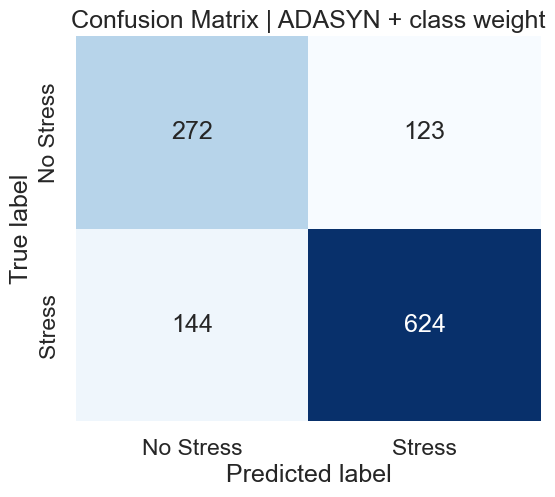

              precision    recall  f1-score   support

   No Stress       0.65      0.69      0.67       395
      Stress       0.84      0.81      0.82       768

    accuracy                           0.77      1163
   macro avg       0.74      0.75      0.75      1163
weighted avg       0.77      0.77      0.77      1163



In [14]:

y_pred_best = best_artifact['predictions']
y_proba_best = best_artifact['probabilities']
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f"Confusion Matrix | {best_artifact['strategy']}")
plt.show()

print(classification_report(y_test, y_pred_best, target_names=['No Stress', 'Stress']))


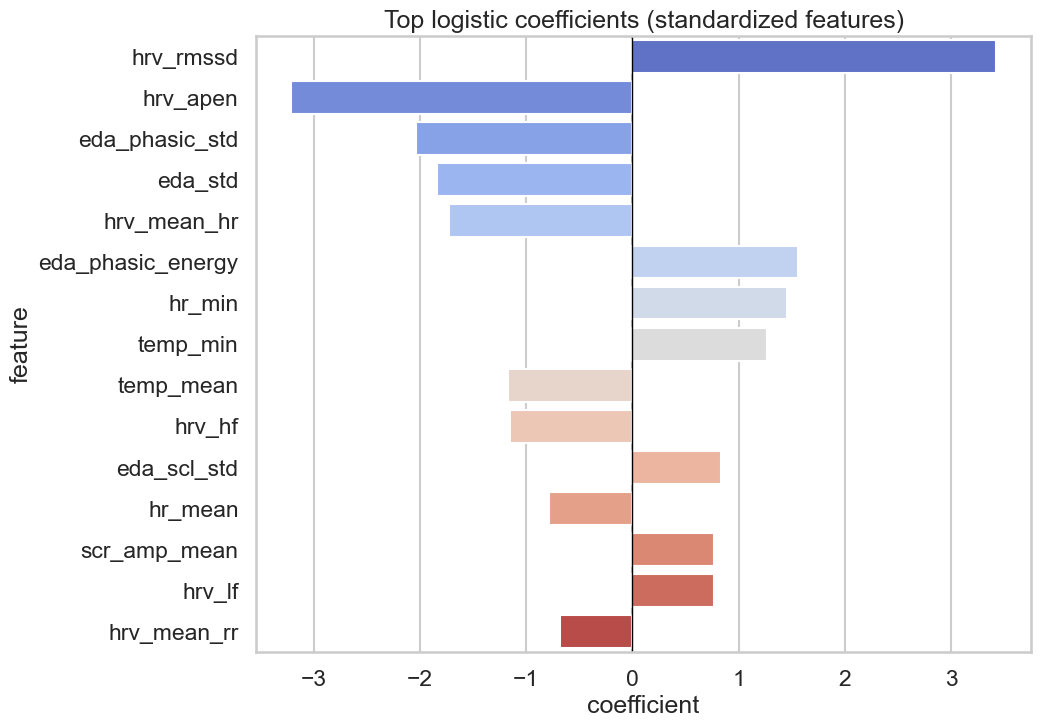

,feature,coefficient,abs_coef
18,hrv_rmssd,3.422482,3.422482
24,hrv_apen,-3.212444,3.212444
4,eda_phasic_std,-2.038602,2.038602
12,eda_std,-1.843929,1.843929
19,hrv_mean_hr,-1.724580,1.724580
5,eda_phasic_energy,1.558781,1.558781
37,hr_min,1.460186,1.460186
27,temp_min,1.271354,1.271354
25,temp_mean,-1.170626,1.170626
21,hrv_hf,-1.148118,1.148118


In [ ]:
coef = best_artifact['model'].named_steps['logreg'].coef_[0]
coef_df = pd.DataFrame({'feature': feature_cols, 'coefficient': coef})
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df.sort_values('abs_coef', ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
sns.barplot(data=coef_df.head(15), x='coefficient', y='feature', palette='coolwarm')
plt.title('Top logistic coefficients (standardized features)')
plt.axvline(0, color='black', linewidth=1)
plt.show()

display(coef_df.head(20))


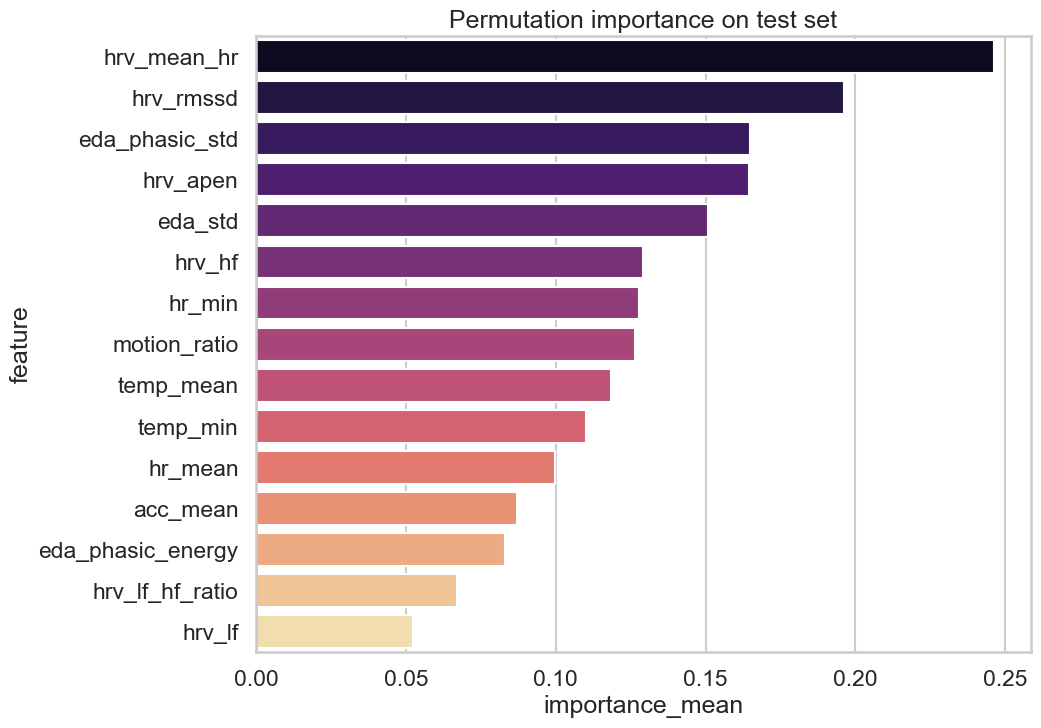

In [16]:

perm = permutation_importance(
    best_artifact['model'],
    X_test,
    y_test,
    n_repeats=20,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
perm_df = pd.DataFrame({
    'feature': feature_cols,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std,
})
perm_df.sort_values('importance_mean', ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
sns.barplot(data=perm_df.head(15), x='importance_mean', y='feature', palette='magma')
plt.title('Permutation importance on test set')
plt.axvline(0, color='black', linewidth=1)
plt.show()


,phase,precision,recall,f1,support
4,aerobic,1.000000,0.870787,0.930931,178
0,Baseline,0.899371,0.959732,0.928571,205
7,unknown,1.000000,0.828283,0.906077,99
1,Opposite Opinion,1.000000,0.714286,0.833333,77
3,TMCT,1.000000,0.695652,0.820513,115
5,anaerobic,1.000000,0.685950,0.813725,121
2,Stroop,0.634146,0.896552,0.742857,44
6,rest,0.000000,0.000000,0.000000,323


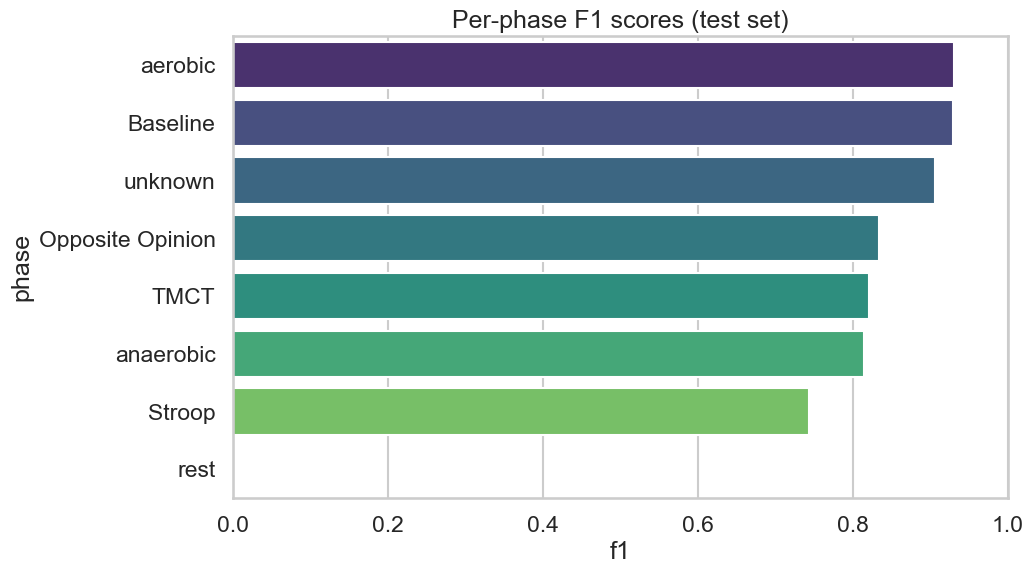

In [17]:

test_meta = test_meta.assign(
    y_true=y_test,
    y_pred=y_pred_best,
    y_proba=y_proba_best,
)

phase_metrics = []
for phase, group in test_meta.groupby('phase'):
    if group.shape[0] < 5:
        continue
    precision, recall, f1, _ = precision_recall_fscore_support(
        group['y_true'], group['y_pred'], average='binary', zero_division=0
    )
    phase_metrics.append({
        'phase': phase,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': group.shape[0],
    })

phase_metrics_df = pd.DataFrame(phase_metrics).sort_values('f1', ascending=False)
display(phase_metrics_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=phase_metrics_df, x='f1', y='phase', palette='viridis')
plt.title('Per-phase F1 scores (test set)')
plt.xlim(0, 1)
plt.show()



## Next Steps

- Export the trained logistic model (and scaler) for integration into the two-stage pipeline once the preferred imbalance strategy is finalized.
- Re-run this notebook periodically as you add new engineered features (e.g., wavelet energies, cross-signal synchrony) to ensure the subject-normalized logistic detector continues to hold up against the XGBoost baseline.
- If you need calibrated probabilities for downstream decision rules, add an isotonic calibration step on the training portion before evaluating on the held-out test set.
